# 4 Local Coupler Circuit

In this notebook, we use Qcircuit to find the spectrum of a four local circuit( the circuit diagram and its paramters is in the appendix) based on the following paper:   
_Automated discovery of superconducting circuits and its application to 4-local coupler design_

First, we import the Qcircuit from circuitClass file and specify a number for each nodes on the circuit. The number for each node should be consecutive integer starts from zero(corresponds to circuit ground.) 

In [1]:
from circuitClass import *

<img src="pics/4localCoupler_pic1.png" width="200" />

We use "Before refine" parameters of the following table 

<img src="pics/4localCoupler_pic2.png" width="700" />

We create the object of Qcircuit by initializing it with `circParam` dictionary.

In [2]:
# cicuitParam is a dictionary that contains the information about the graph structure,
# capacitor values, inductor values, and Josephson Junction Values.
# inductors should be in Henry
# capacitors should be in Farad
# JJ energies should be in Hz
circuitParam={'graph':[[1,3],[2,0],[2,3],[3,0],[1,2]],
            'inductors':[293*pH,None,98.1*pH,None,None],
            'capacitors':[98.8*fF,15*fF,38.7*fF,67.5*fF,0],
            'JJs':[None,187*GHz,None,192*GHz,1560*GHz]}

# cr is an object of Qcircuit
cr1 = Qcircuit(circuitParam)

By `cr1.setModeNumbers([m1,m2,m3])`, we set the accuracy of the solver. For this circuit, Qcircuit converges with $m_1=19,m_2=19$, and $m_3=21$. Next, we should call `cr1.configure()` to set up the equations needed to calculate the Hamiltonian.

In [3]:
# call this function to set the truncation number for each mode of the circuit. 
cr1.setModeNumbers([19,19,21])

# call this function to set up equations and preprocesses needed to calculate the Hamiltonian.
cr1.configure()

By applying `cr1.getExternalLinks()`, we find the inductive loops that we can apply external fluxes to them.

In [4]:
cr1.getExternalLinks()

[[1, 2, 3], [0, 2, 3]]

Qcircuit tells us that we can apply external fluxes to inductive loops created by the `[1,2,3]` and `[0,2,3]` cycles. Therefore, by calling `cr1.setExcitation([phiExt,0])`, we apply array of external fluxes to `[1,2,3]` loop and 0 external flux to `[0,2,3]` loop.

In [5]:
# set external fluxes for each inductive loops of the circuit.
phiExt = np.linspace(0.0,0.2,10)*2*np.pi
cr1.setExcitation([phiExt,0])

By running the below cell, Qcircuit calculates the Hamiltonian and find the first 3 eigenvalues and eigenvectors of the system for each external fluxes.

In [6]:
# run the solver to calculate the eigenvalues and eigenvectors of the Hamiltonian for 
# specific number of bands
cr1.run(numBand = 3,showLoading=False)

The eigenValues are stored in the `cr1.HamilEigVal` variable in units of angular frequancy. The first index of the `cr1.HamilEigVal` refers to band number, and the second index refers to the index of external fluxes specified in `phiExt`. Therefore, the next cell plots the spectrum of the circuit.

Text(0, 0.5, '$\\omega_i$ GHz')

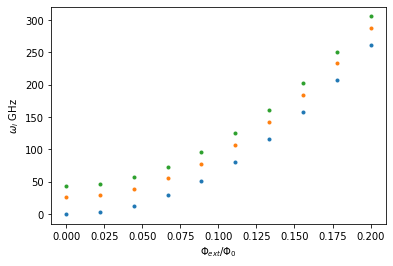

In [7]:
plt.figure()
for i in range(3):
    plt.plot(phiExt/2/np.pi,(cr1.HamilEigVal[i,:]-np.min(cr1.HamilEigVal[0,:])).real/(GHz*2*np.pi),'.')

plt.xlabel("$\Phi_{ext}/\Phi_0$")
plt.ylabel("$\omega_i$ GHz")

### Paper Method
To check the result of the Qcircuit, We use the paper method to calculate the Hamiltonian of the circuit and find its spectrum

<img src="pics/4localCoupler_pic3.png" width="700" />


In [8]:
R = np.array([[1,0,1],[0,1,1],[1,1,1]])
RInv = np.linalg.inv(R)
Cx = cr1.getMatC()
Lx = cr1.getMatL()
_ ,S = np.linalg.eig(Lx)
lRotated = R @ Lx @ R 
cInvRotated = RInv @ np.linalg.inv(Cx) @ RInv

Z1 = np.sqrt(cInvRotated[0,0]/lRotated[0,0])
Z2 = np.sqrt(cInvRotated[1,1]/lRotated[1,1])
omega = np.sqrt(np.diag(cInvRotated)*np.diag(lRotated))

alpha1 = 1j*2*np.pi/Phi0*np.sqrt(hbar*Z1/2)
alpha2 = 1j*2*np.pi/Phi0*np.sqrt(hbar*Z2/2)

In [9]:
m = [10,15,25]
JJ = cr1.JJ.copy()
def Hamil(phiVar,phiFix):
    I1 = q.qeye(m[0]);
    num1 = q.num(m[0]);
    intr1 = q.destroy(m[0]) - q.create(m[0])
    I2 = q.qeye(m[1]);
    num2 = q.num(m[1]);
    intr2 = q.destroy(m[1]) - q.create(m[1])
    I3 = q.qeye(m[2]);
    charge3 = q.charge((m[2]-1)/2)
    d3 = cr1.chargeDisp(m[2])
    
    
    HLC = omega[0]*q.tensor(num1,I2,I3) +\
    omega[1]*q.tensor(I1,num2,I3) +\
    0.5*(2*e)**2*cInvRotated[2,2]/hbar*q.tensor(I1,I2,charge3)*q.tensor(I1,I2,charge3)-\
    1/np.sqrt(Z1*Z2)/2*cInvRotated[0,1]*q.tensor(intr1,intr2,I3) -\
    1j*np.sqrt(1/(2*hbar*Z1))*(2*e)*cInvRotated[0,2]*q.tensor(intr1,I2,charge3) -\
    1j*np.sqrt(1/(2*hbar*Z2))*(2*e)*cInvRotated[1,2]*q.tensor(I1,intr2,charge3)
    
    alpha1 = 1j*2*np.pi/Phi0*np.sqrt(hbar*Z1/2)
    alpha2 = 1j*2*np.pi/Phi0*np.sqrt(hbar*Z2/2)
    
    HJ12 = -JJ[4]/2*np.exp(1j*phiVar)*q.tensor(q.displace(m[0],alpha1),q.displace(m[1],-alpha2),I3)
    HJ22 = -JJ[1]/2*np.exp(1j*phiFix)*q.tensor(I1,q.displace(m[1],alpha2),d3);
    HJ33 = -JJ[3]/2*q.tensor(q.displace(m[0],alpha1),q.displace(m[1],alpha2),d3)
    
    H = HLC +  (HJ12+HJ12.dag()) + HJ22+HJ22.dag() + (HJ33+HJ33.dag())
    return H

In [10]:
HamilEig = np.zeros((m[0]*m[1]*m[2],len(phiExt)),dtype='complex');
for i in range(len(phiExt)):
    print(i)
    H = Hamil(phiVar = phiExt[i], phiFix = 0);
    eigenValues , eigenVectors = H.eigenstates();
    HamilEig[:,i] = eigenValues

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, '($\\omega_i-\\omega_0$)GHz')

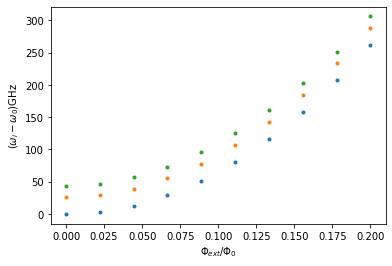

In [11]:
plt.figure()
for i in range(3):
    plt.plot(phiExt/2/np.pi,(HamilEig[i,:]-np.min(HamilEig[0,:])).real/GHz/2/np.pi,'.')

plt.xlabel("$\Phi_{ext}/\Phi_0$")
plt.ylabel("($\omega_i-\omega_0$)GHz")